In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import joypy
from functools import reduce
from lr.text_processing.util import pre_process_nli_df, get_vocab_count
from lr.text_processing.transformations.util import syn_h2tranformation, syn_p2tranformation
from lr.text_processing.transformations.util import syn2tranformation
from lr.text_processing.transformations.util import get_augmented_data
from lr.text_processing.transformations.structural import invert, entailment_internalization
from lr.training.util import get_binary_label, get_ternary_label
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
from lr.stats.matched_comparison import get_disagreement_statistics
from lr.stats.bootstrap import get_bootstrap_replications, apply_transformation_under_H0
from IPython.display import HTML, display
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# load data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
df = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(df)
pre_process_nli_df(dev)

## Creating lexical masking

In [3]:
head = 800
mwords = 250

c = get_vocab_count(df.head(head))
mask = {i[0]: "" for i in c.most_common(mwords)}

# get pct x t

In [4]:
trials = 30
B = 50
max_features = 500

label_translation = get_ternary_label
# label_translation = get_binary_label

# transformation = syn2tranformation(mask)
# transformation = syn_h2tranformation(mask)
# transformation = invert
transformation = entailment_internalization
# transformation = syn_p2tranformation(mask)

trans_df = lambda x: get_augmented_data(df=x,
                                        transformation=transformation,
                                        frac=1)




pcts = np.linspace(0, 1, trials)
ids = [[i] * B for i in pcts]
ids = reduce(lambda x,y: x + y, ids)

stats = []
ent_stats = []
# non_ent_stats = []
contra_stats = []
neutral_stats = []



hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}

for pct in tqdm(ids):
        
    train_b = get_bootstrap_replications(df)
    dev_b = get_bootstrap_replications(dev)

    train_b_aug = get_augmented_data(df=df,
                                     transformation=transformation,
                                     frac=pct)

    dev_b_original, dev_b_t = apply_transformation_under_H0(dev_b, df_transformation_f=trans_df)

#     dev_b_original, dev_b_t = dev_b.copy(), trans_df(dev_b)



    lr = LRWrapper(hyperparams)
    lr.fit(train_b_aug)


    st = get_disagreement_statistics(df=dev_b_original,
                                     df_t=dev_b_t,
                                     model=lr,
                                     label_translation=label_translation)


    neutral_st = get_disagreement_statistics(df=dev_b_original.query("label=='neutral'"),
                                             df_t=dev_b_t.query("label=='neutral'"),
                                             model=lr,
                                             label_translation=label_translation)

    contra_st = get_disagreement_statistics(df=dev_b_original.query("label=='contradiction'"),
                                             df_t=dev_b_t.query("label=='contradiction'"),
                                             model=lr,
                                             label_translation=label_translation)

    ent_st = get_disagreement_statistics(df=dev_b_original.query("label=='entailment'"),
                                             df_t=dev_b_t.query("label=='entailment'"),
                                             model=lr,
                                             label_translation=label_translation)

#     non_ent_st = get_disagreement_statistics(df=dev.query("label=='non_entailment'"),
#                                              df_t=dev_t.query("label=='non_entailment'"),
#                                              model=lr,
#                                              label_translation=label_translation)

    ent_stats.append(ent_st)
    neutral_stats.append(neutral_st)
    contra_stats.append(contra_st)
    stats.append(st)
#     non_ent_stats.append(non_ent_st)



del lr, train_b, dev_b
    

result = pd.concat(stats)
result.index = ids
result.index.name = "pcts"

ent_result = pd.concat(ent_stats)
ent_result.index = ids
ent_result.index.name = "pcts"

contra_result = pd.concat(contra_stats)
contra_result.index = ids
contra_result.index.name = "pcts"

neutral_result = pd.concat(neutral_stats)
neutral_result.index = ids
neutral_result.index.name = "pcts"

# non_ent_result = pd.concat(non_ent_stats)
# non_ent_result.index = pcts
# non_ent_result.index.name = "pcts"

100%|██████████| 1500/1500 [09:10<00:00,  2.95it/s]


In [5]:
result_mean = result.reset_index().groupby("pcts").mean()
ent_result_mean = ent_result.reset_index().groupby("pcts").mean()
contra_result_mean = contra_result.reset_index().groupby("pcts").mean()
neutral_result_mean = neutral_result.reset_index().groupby("pcts").mean()

# Plots

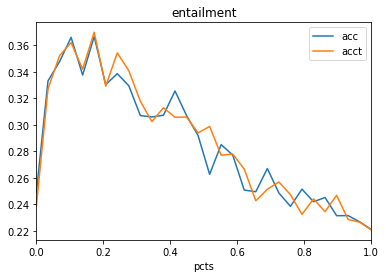

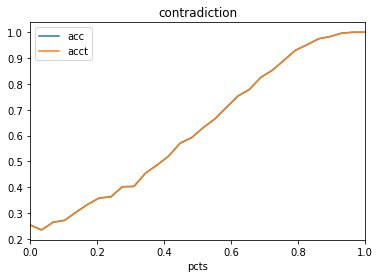

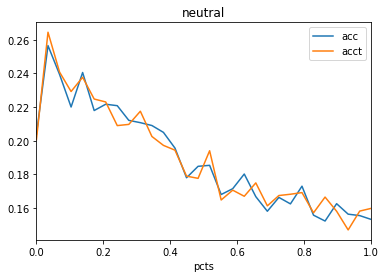

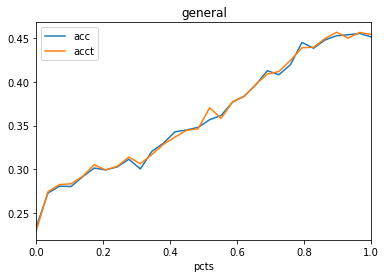

In [6]:
ent_result_mean[["acc", "acct"]].plot(title="entailment");
contra_result_mean[["acc", "acct"]].plot(title="contradiction");
neutral_result_mean[["acc", "acct"]].plot(title="neutral");
result_mean[["acc", 'acct']].plot(title="general");

## Plots TEST

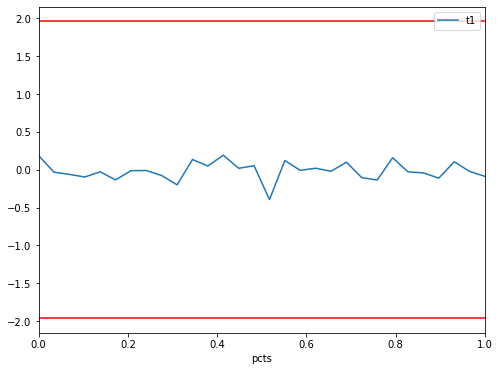

In [7]:
alpha = 0.05
z_alpha_2 =  scipy.stats.norm.ppf(1  - (alpha/2))
paired_t_reject_H0 = result_mean.t1.apply(np.abs) > z_alpha_2
paired_t_reject_H0 = paired_t_reject_H0.apply(lambda x: "reject H0" if x else "retain  H0")
paired_t_reject_H0.name = "paired_t"

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=z_alpha_2, color='r', linestyle='-')
plt.axhline(y=-z_alpha_2, color='r', linestyle='-')
result_mean[["t1"]].plot(ax=ax);

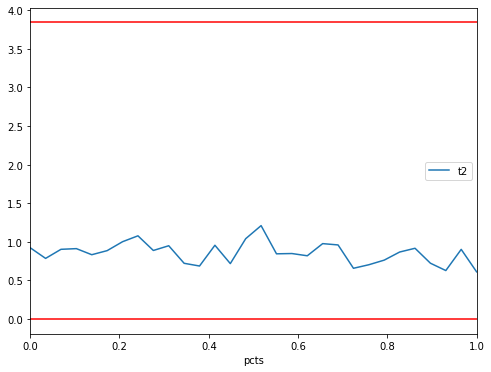

In [8]:
chi_2_alpha =  scipy.stats.chi2.ppf(1 - alpha, df=1)
cochran_reject_H0 = result_mean.t2 > chi_2_alpha
cochran_reject_H0 = cochran_reject_H0.apply(lambda x: "reject H0" if x else "retain  H0")
cochran_reject_H0.name = "cochran"

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=chi_2_alpha, color='r', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')

result_mean[["t2"]].plot(ax=ax);

## Tests
### basic info

In [9]:
tests = pd.DataFrame([paired_t_reject_H0, cochran_reject_H0]).transpose()
disagreement = tests[~ (tests.cochran == tests.paired_t)]
display(HTML(tests.cochran.value_counts().to_frame().to_html()))
display(HTML(tests.paired_t.value_counts().to_frame().to_html()))
display(HTML(disagreement.to_html()))

,cochran
retain H0,30


,paired_t
retain H0,30


,paired_t,cochran
pcts,,


### p-values

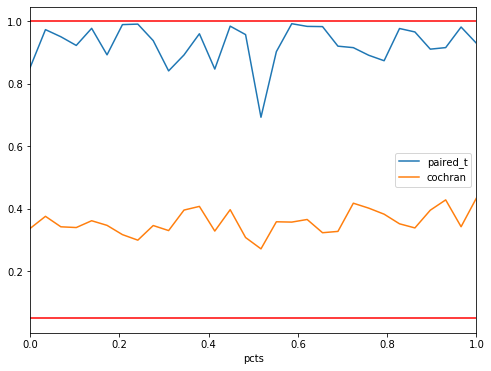

In [10]:
p_normal = lambda x: 2*scipy.stats.norm.cdf(- np.abs(x))
p_chi2 = lambda x: 1 - scipy.stats.chi2.cdf(x,df=1)
p_t1 = result_mean.t1.map(p_normal)
p_t1.name = "paired_t"
p_t2 = result_mean.t2.map(p_chi2)
p_t2.name = "cochran"
p_values = pd.DataFrame([p_t1, p_t2]).transpose()

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=alpha, color='r', linestyle='-')
p_values.plot(ax=ax);

## Interval analysis

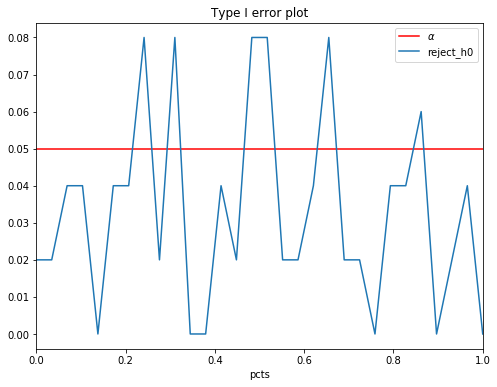

In [11]:
result_ = result.reset_index()
result_.loc[:, "p_values"] = result_.t1.map(p_normal)
result_.loc[:, "reject_h0"] = (result_.p_values < alpha).astype(int)

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=alpha, color='r', linestyle='-', label=r"$\alpha$")
result_.groupby("pcts").mean().reject_h0.plot(ax=ax, title="Type I error plot");
plt.legend(loc="best");

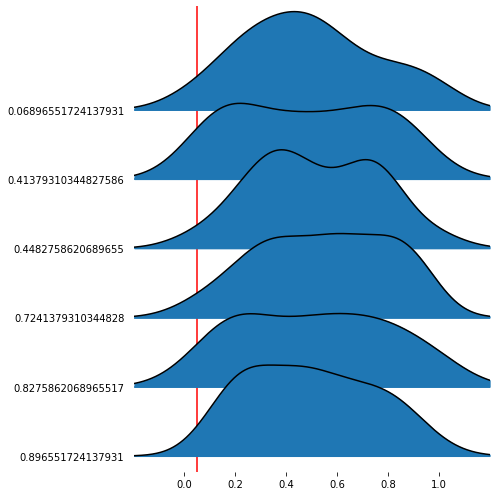

In [12]:
good = result_.groupby("pcts").mean().reject_h0[result_.groupby("pcts").mean().reject_h0 <= alpha]
i_s = np.random.choice(good.index.unique(), 6)
result_good = result_[result_['pcts'].isin(i_s)]
fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.axvline(x=alpha, color='r', linestyle='-');
joypy.joyplot(result_good, by="pcts", column="p_values",ax=ax);
plt.axvline(x=alpha, color='r', linestyle='-');

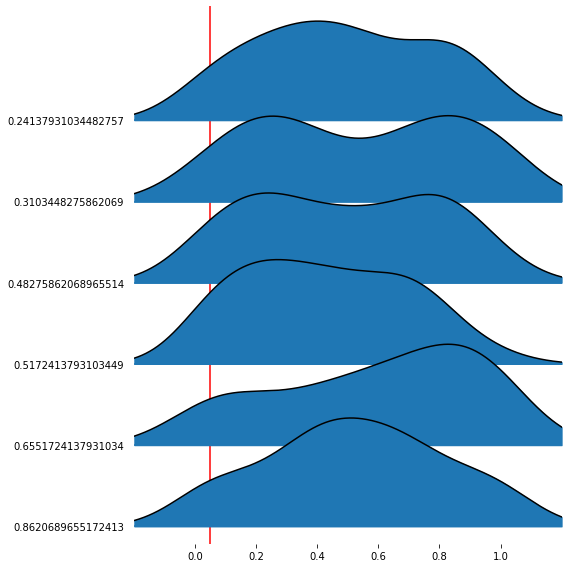

In [13]:
bad = result_.groupby("pcts").mean().reject_h0[result_.groupby("pcts").mean().reject_h0 > alpha]
result_bad = result_[result_['pcts'].isin(bad.index.unique())]
fig, ax = plt.subplots(1,1,figsize=(8,8))
joypy.joyplot(result_bad, by="pcts", column="p_values",ax=ax);
plt.axvline(x=alpha, color='r', linestyle='-');